In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.grimoire as Grimoire
from src.grimoire import By
import src.decks as Decks


Carico le carte dal grimorio di Kodama of the West Tree


In [2]:
commander = "Kodama of the West Tree"
# grim = Grimoire.Grimoire(omnicomprehensive=True)
# Decks.fetch(By.COMMANDER, commander,do_load=False,upper_limit=1000)
grim = Grimoire.fetch(By.COMMANDER,commander)


Carico le carte dal grimorio di Kodama of the West Tree


In [3]:
from src.card import Filters
# Crea la matrice di correlazione
df = grim.dataframe( 
    positive_filters=[
        Filters.isLegalInCommander,
        # Filters.isCreature,
        # Filters.isGreen
        # Filters.isColorless
    ], 
    negative_filters=[
        Filters.isToken
        # Filters.isLegendary
    ],
    additional_data={
        # "is_creature": lambda card: int(Type.Creature.name in card.types),
        # "#keywords" : lambda card: len(card.keywords),
        # "#words" : lambda card: card.text.count(' ')+1,
        # "is_green": lambda card: int(card.color_identity['G']),
        # "is_black": lambda card: int(card.color_identity['B']),
        # "is_colorless": lambda card: int(all(not v for v in card.color_identity.values())),
        "is_legendary": lambda card: int("Legendary" in card.super_types),
        "#act_abilities": lambda card: int(card.count_active_abilities()),
        "#trigg_abilities": lambda card: int(card.count_trigger_abilities()),
        "#mana_production": lambda card: int(card.count_mana_production())
    })

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df.copy()
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
df_scaled[numeric_cols] =  scaler.fit_transform(df[numeric_cols])
correlation_matrix = df_scaled.corr()

In [5]:
grim.remove(9092494)

True

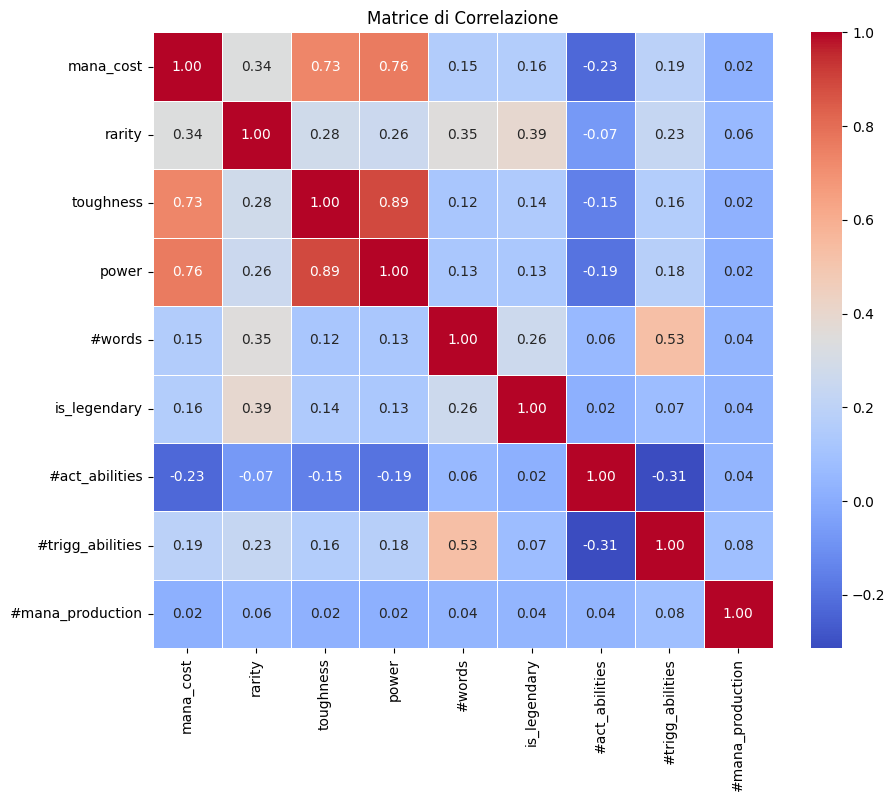

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Opzionalmente, crea una heatmap per visualizzare meglio la correlazione
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione')
plt.show()


In [5]:
vectors = grim.vectorize()

# def percentuale(count):
#     return round(count/len(grim)*100,2)

# print(f'Su un totale di {len(grim)} carte:')
# for term, count in vectors.items():
#     space = ' ' if len(str(percentuale(count))) <5 else ''
#     print(f'{space}{percentuale(count)}%: {count} sono {term}')

In [6]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np


# Funzione per aggiornare la heatmap
def update_heatmap(limit):
    # Crea una maschera booleana per nascondere le annotazioni non significative
    mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

    # Crea una matrice di annotazioni, sostituendo i valori non significativi con NaN
    annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

    # Stampa la heatmap senza annotazioni per le celle non significative
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
    plt.title(f'Heatmap with Limit: {limit}')
    plt.show()

# Crea un widget per limit
limit_slider = widgets.FloatSlider(value=0.15, min=0.00, max=0.23, step=0.001, description='Limit:')


# # Mostra la heatmap iniziale
# update_heatmap(limit_slider.value)

# Collega il widget alla funzione di aggiornamento
widgets.interactive(update_heatmap, limit=limit_slider)

array([[1.        , 0.29522746, 0.29522746, ..., 0.29522746, 1.        ,
        0.29522746],
       [0.29522746, 1.        , 1.        , ..., 1.        , 0.16695677,
        1.        ],
       [0.29522746, 1.        , 1.        , ..., 1.        , 0.07430376,
        1.        ],
       ...,
       [0.29522746, 1.        , 1.        , ..., 1.        , 0.1589627 ,
        1.        ],
       [1.        , 0.16695677, 0.07430376, ..., 0.1589627 , 1.        ,
        0.33920026],
       [0.29522746, 1.        , 1.        , ..., 1.        , 0.33920026,
        1.        ]])

In [8]:


from src.similarity import SimilarityMethod as SimMeth
import importlib
importlib.reload(Grimoire)

vector_matrix = Grimoire.precompute_vectors(grim)


In [9]:

methods = [SimMeth.COSINE, SimMeth.EUCLIDEAN, SimMeth.PEARSON_CORRELATION]
matrices, times = Grimoire.similarity_matrix(vector_matrix,methods)

TypeError: cannot unpack non-iterable SimilarityMethod object

In [10]:
print(methods)
for m in methods:
    print(m)

[<SimilarityMethod.COSINE: ('cosine', <src.similarity.FunctionProxy object at 0x70ab80528e20>)>, <SimilarityMethod.EUCLIDEAN: ('euclidean', <src.similarity.FunctionProxy object at 0x70ab80528dc0>)>, <SimilarityMethod.PEARSON_CORRELATION: ('pearson', <src.similarity.FunctionProxy object at 0x70ab80528d60>)>]


In [ ]:
print(times)

In [ ]:
for i, matrix in enumerate(matrices):
    print(f"{matrix}\n\n")

In [ ]:

rows, cols = matrix.shape

if rows != cols:
    raise ValueError("La matrice non è quadrata.")
if not (matrix == matrix.T).all():
    raise ValueError("La matrice non è simmetrica.")
if (matrix < 0).any():
    raise ValueError("La matrice contiene valori negativi.")

In [9]:

# import imageio.v2 as imageio
# # Definisci i limiti per la GIF
# limits = np.arange(0, 0.24, 0.01)

# # Lista per salvare i frame
# frames = []

# # Genera i frame
# for limit in limits:
#     plt.figure(figsize=(10, 8))
    
#     # Crea una maschera booleana per nascondere le annotazioni non significative
#     mask_annot = (correlation_matrix < -limit) | (correlation_matrix > limit)

#     # Crea una matrice di annotazioni
#     annot = np.where(mask_annot, np.round(correlation_matrix, 2), np.nan)

#     # Stampa la heatmap
#     sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8}, mask=np.isnan(annot))
#     plt.title(f'Heatmap with Limit: {limit:.2f}')
    
#     # Salva il frame come immagine
#     plt.savefig(f'frame_{limit:.2f}.png')
#     plt.close()

#     # Aggiungi il frame alla lista
#     frames.append(imageio.imread(f'frame_{limit:.2f}.png'))

# # Crea una GIF animata
# imageio.mimsave('heatmap_animation.gif', frames, duration=4)

# # Rimuovi le immagini temporanee (opzionale)
# import os
# for limit in limits:
#     os.remove(f'frame_{limit:.2f}.png')

# print("GIF animata creata: heatmap_animation.gif")

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

deck_ids = list(grim.get_all_deck_ids())
treshold = 3
model = AgglomerativeClustering(distance_threshold=treshold, n_clusters=None)

distanze = 1 - matrix
labels = model.fit_predict(distanze)

# Numero di cluster
n_clusters = len(set(labels))
print(f"Numero di cluster: {n_clusters}")

# Visualizza il dendrogramma
plt.figure(figsize=(80, 7))
dendrogram = sch.dendrogram(sch.linkage(distanze, method='complete'), labels=deck_ids)
plt.axhline(y=treshold, color='r', linestyle='--')  # Imposta una soglia per tagliare i cluster
plt.show()

In [ ]:

# Stampa le etichette dei cluster per ogni punto
print("Etichette dei cluster:", labels)

# 4. Visualizza i dati e i cluster
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow')
plt.title('Agglomerative Hierarchical Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# 5. Visualizzazione del dendrogramma
linked = linkage(data, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Indice dei punti')
plt.ylabel('Distanza')
plt.show()

In [12]:
# Controlla se ci sono valori negativi
if np.any(matrix > 1):
    print("La matrice di distanze contiene valori negativi.")

In [ ]:

from sklearn.metrics import silhouette_score
# Calcola il silhouette score
score = silhouette_score(distanze, labels, metric='precomputed')
print(f'Silhouette Score: {score:.3f}')

In [ ]:

from scipy.cluster.hierarchy import linkage

# Clustering agglomerativo
Z = linkage(distanze, method='average')

# Calcola le distanze per il metodo del gomito
max_distanze = []
for i in range(1, len(matrix)):
    # Aggiungi la distanza massima dal dendrogramma
    max_distanze.append(max(Z[:i, 2]))

# Grafico del metodo del gomito
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(matrix)), max_distanze, marker='o')
plt.title('Metodo del Gomito per Clustering Agglomerativo')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Distanza Massima')
plt.grid()
plt.show()